In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from time import time
import pickle
import os

from setup.univ_setup import *
from setup.utils import *
from factor_mining.combine_factors import *
from factor_mining.factor_preprocessing import *
from performance_analysis.pa_core import *

from backtest.BackTestSinglePeriod import *
from backtest.BackTest import *
from backtest.percentile_portfolio import *

from factor_mining.attribution.factor_correlation import *

from factor_mining.Mark0 import * # This is alpha file

In [3]:
### universe setup ###
print('Setup R3000 universe')
datadir = '/home/derek-qi/Documents/R3000_Data/data/r3000/'
start = time()
if os.path.exists(datadir + 'univ.pkl'):
    print('use existing binary file')
    with open(datadir + 'univ.pkl', 'rb') as univ_fh:
        univ = pickle.load(univ_fh)
    
else:
    print('construct from csv')
    big_table_dir = datadir + 'big_table_full_v4.csv'
    univ = univ_setup(big_table_dir)
    # filt_by_name(univ) # This is slow！
    with open(datadir + 'univ.pkl','wb') as fh:
        pickle.dump(univ, fh)
end = time()
print('%f seconds' % (end - start))

filt_na(univ)
import warnings
warnings.filterwarnings("ignore")

### model configuration ###
print('Calculate factors')
# define and calculate all factors
factors = alpha_four_factors(univ)
factor_names = list(factors.keys())

# concat into factor exposure matrices
factor_exp_mat = combine_factors(factors)
filt_na(factor_exp_mat)

### Filt the universe ###
print('Filt the untradables')

filt_byval(univ, 'in_r3000', 0)
filt_byval(univ, 'price', 10)
filt_byval(univ, 'not_in_MA', 0)
filt_byval(univ, 'volume', 1500000)
factor_exp_mat = merge(factor_exp_mat, univ, right_cols=['f_log_ret_1', 'industry'])
print('Done')

# Preprocessing factor expsure matrices
print('Scale each factor')
factor_exp_mat = process_batch(factor_exp_mat, standardize, factor_names=factor_names)
print('Winsorize with +/- 3 std')
factor_exp_mat = process_batch(factor_exp_mat, winsorize_std, factor_names=factor_names)
print('Done')

Setup R3000 universe
use existing binary file
0.429428 seconds
Calculate factors
Filt the untradables
Done
Scale each factor
Winsorize with +/- 3 std
Done


In [4]:
datelst = sorted(univ.keys())
print(datelst[0], datelst[-1])
start_date = datetime(2011, 1, 1)
end_date = datetime(2016, 12, 31)
# crdf = factor_correlation(univ, factor_exp_mat, lag = 0, demean='industry')

2010-04-30 00:00:00 2017-04-28 00:00:00


In [15]:
factor_names = list(factors.keys())

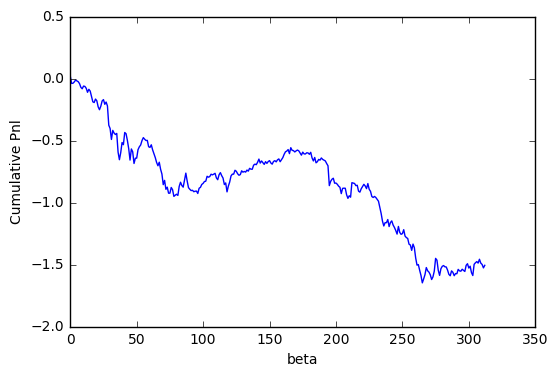

Volatility: 0.265288
Sharpe Ratio: -0.943502


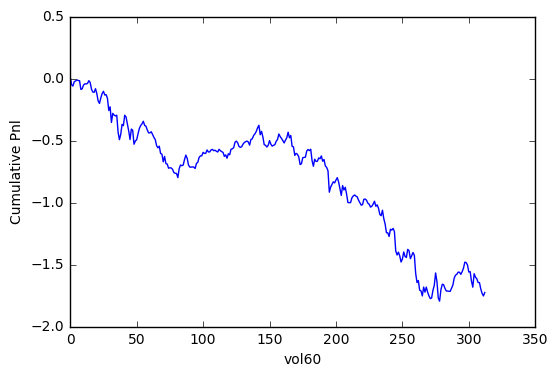

Volatility: 0.293551
Sharpe Ratio: -0.976653


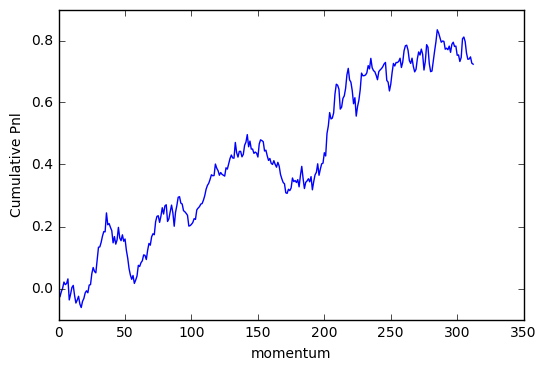

Volatility: 0.167271
Sharpe Ratio: 0.718675


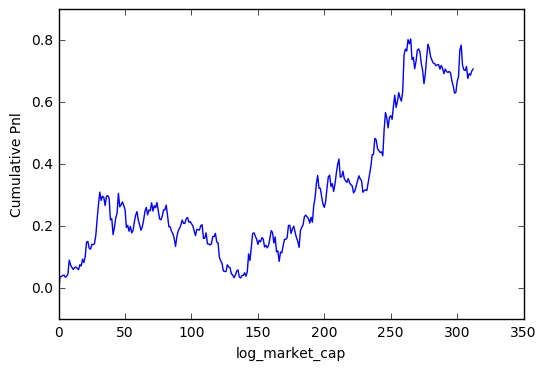

Volatility: 0.180163
Sharpe Ratio: 0.652529


In [17]:
for fn in factor_names:
    # Top 5 percent
    spcalc = PercentilePtflSpcalc(signal=fn, sel_range=[95, 100])
    bt = BackTest(univ=univ, factor_exp_mat=factor_exp_mat, daterange=[start_date, end_date], sp_calc=spcalc, rebal=1)
    ptfl_lst_95_100, pnl_lst_95_100 = bt.calc_pnl()
    # Bottom 10 percent
    spcalc = PercentilePtflSpcalc(signal=fn, sel_range=[0, 5])
    bt = BackTest(univ=univ, factor_exp_mat=factor_exp_mat, daterange=[start_date, end_date], sp_calc=spcalc, rebal=1)
    ptfl_lst_0_5, pnl_lst_0_5 = bt.calc_pnl()

    pnl = np.asarray(pnl_lst_95_100) - np.asarray(pnl_lst_0_5)
    plt.plot(np.cumsum(pnl))
    plt.xlabel(fn)
    plt.ylabel('Cumulative Pnl')
    plt.show()
    
    sharpe = np.nanmean(pnl) / np.sqrt(np.nanvar(pnl)) * np.sqrt(52)
    print('Volatility: %f' % np.sqrt(np.nanvar(pnl) * 52))
    print('Sharpe Ratio: %f' % sharpe)

In [10]:
from itertools import product
rebal = [1]
# factor_names = ['momentum', 'vol60', 'beta']
step = 5
ranges = [[i * step, (i + 1) * step] for i in range(100//step)]
daterange = [start_date, end_date]
config_iter = product(rebal, factor_names, ranges)
iter_result = {}
for r, f, g in config_iter:
#     print(r,f,g)
    spcalc = PercentilePtflSpcalc(signal=f, sel_range=g, weighting='equal')
    bt = BackTest(univ, factor_exp_mat, daterange, spcalc, rebal=r)
    ptfl_lst, pnl_lst = bt.calc_pnl(demean='industry')
    k = f + '_' + str(g[0]) + '_' + str(g[1]) + '_' + str(r)
    iter_result[k] = (np.nanmean(pnl_lst), np.sqrt(np.nanvar(pnl_lst)))

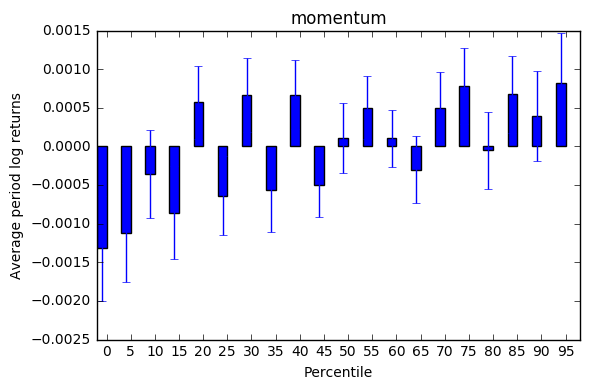

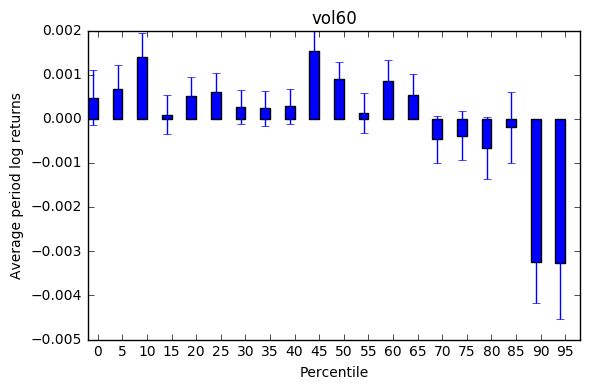

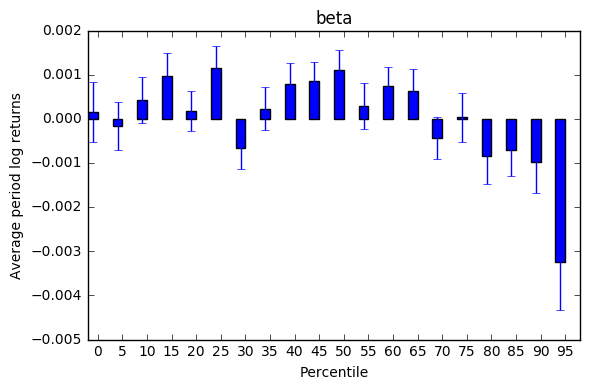

In [11]:
for n in factor_names:
    c = len(pnl_lst)
    x = [5*i for i in range(20)]
    y_1 = [iter_result[n+'_'+str(i)+'_'+str(i+5)+'_1'][0] for i in x]
    s_1 = [iter_result[n+'_'+str(i)+'_'+str(i+5)+'_1'][1] / np.sqrt(c) for i in x]
    
    # Here comes the plots
    bar_width = 2
    week = plt.bar(np.array(x), y_1, width=bar_width, yerr=s_1, color='b')

    plt.xlabel('Percentile')
    plt.ylabel('Average period log returns')
    plt.title(n)
    plt.xticks(np.array(x) + bar_width, x)
    plt.legend()

    plt.tight_layout()
    plt.show()